In [2]:
import os
import numpy as np
import torch
import argparse
import shutil
import time
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import torch.nn.functional as F
import sys
sys.path.append('../')
import utils.losses as losses
import utils.detectors as detectors
import utils.metrics as metrics
import utils.optimizer as optim
from models.model_builder import getModel
from datasets.data_loader import getDataLoader
from torchvision import transforms as trn
from config import cfg
from PIL import Image

In [3]:
cfg = dict()
cfg['network_kind'] = 'wrn'
cfg['depth'] = 40
cfg['widen_factor'] = 2
cfg['num_classes'] = 10
cfg['drop_rate'] = 0.3
model = getModel(cfg)

In [4]:
checkpoint = torch.load("/home/sr2/Hyeokjun/OOD-saige/results/wrn_cifar10_baseline/ckpt/checkpoint_epoch_100.pyth", map_location="cpu")
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

In [4]:
cfg['in_dataset'] = dict()
cfg['in_dataset']['dataset'] = 'Severstal'
cfg['in_dataset']['targets'] = ['ok','1', '2']
cfg['in_dataset']['train_transform'] = trn.Compose([trn.RandomHorizontalFlip(),
                                         trn.RandomCrop(224),
                                         trn.ToTensor()])
cfg['in_dataset']['valid_transform'] = trn.Compose([trn.CenterCrop(224),
                                         trn.ToTensor()])
cfg['in_dataset']['data_root'] = '/home/sr2/HDD2/Openset/'
cfg['in_dataset']['split_root'] = '/home/sr2/Hyeokjun/OOD-saige/datasets/data_split/'

# DataLoader config
cfg['dataloader'] = dict()
cfg['dataloader']['batch_size'] = 20
cfg['dataloader']['num_workers'] = 1
cfg['dataloader']['pin_memory'] = True


in_valid_loader = getDataLoader(ds_cfg=cfg['in_dataset'],
                                    dl_cfg=cfg['dataloader'],
                                    split="valid")

Dataset Severstal ready.


In [5]:
cfg['in_dataset'] = dict()
cfg['in_dataset']['dataset'] = 'cifar10'
cfg['in_dataset']['train_transform'] = trn.Compose([trn.RandomHorizontalFlip(),
                                         trn.RandomCrop(32),
                                         trn.ToTensor()])
cfg['in_dataset']['valid_transform'] = trn.Compose([trn.CenterCrop(32),
                                         trn.ToTensor()])
cfg['in_dataset']['data_root'] = '/home/sr2/HDD2/Openset/'
cfg['in_dataset']['split_root'] = '/home/sr2/Hyeokjun/OOD-saige/datasets/data_split/'

# DataLoader config
cfg['dataloader'] = dict()
cfg['dataloader']['batch_size'] = 20
cfg['dataloader']['num_workers'] = 1
cfg['dataloader']['pin_memory'] = True


in_valid_loader = getDataLoader(ds_cfg=cfg['in_dataset'],
                                    dl_cfg=cfg['dataloader'],
                                    split="valid")

Files already downloaded and verified
Dataset CIFAR10 ready.


In [6]:
dataloader_iterator = iter(in_valid_loader)

In [9]:
(data, target) = next(dataloader_iterator)
data = data.cuda()
print(target)
logit = model(data)
print(torch.max(F.softmax(logit, dim=1),dim=1))

tensor([4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6])
torch.return_types.max(
values=tensor([0.9564, 0.9998, 0.9994, 0.9998, 0.9999, 0.9995, 1.0000, 0.9919, 0.9986,
        0.9989, 0.9999, 0.9998, 0.5427, 0.9985, 0.9982, 0.9998, 1.0000, 0.9981,
        0.5206, 0.7564], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 2, 3, 8, 8, 7, 7, 5, 3],
       device='cuda:0'))


In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [96]:
bs = 3
out_features = 5
in_features = 10
alpha = 1
# weights = nn.Parameter(torch.Tensor(out_features, in_features))
# bias = nn.Parameter(torch.Tensor(out_features))
weights = torch.rand((out_features, in_features))
bias = torch.rand((out_features,))
features = torch.rand((bs, in_features))

def euclidean_distances(features, prototypes, pnorm):
    return F.pairwise_distance(features.unsqueeze(2), prototypes.t().unsqueeze(0), p=pnorm)


In [97]:
weights

tensor([[0.2792, 0.5562, 0.5294, 0.2019, 0.0070, 0.6183, 0.1054, 0.3990, 0.7386,
         0.2678],
        [0.4292, 0.6393, 0.4971, 0.3767, 0.9255, 0.3906, 0.0946, 0.7144, 0.4681,
         0.3511],
        [0.2815, 0.5964, 0.9384, 0.5961, 0.6422, 0.8453, 0.6853, 0.9122, 0.9689,
         0.5580],
        [0.6468, 0.9789, 0.8526, 0.0362, 0.8766, 0.9725, 0.0280, 0.0522, 0.3910,
         0.4061],
        [0.5719, 0.6909, 0.1939, 0.1932, 0.4687, 0.8602, 0.8138, 0.1008, 0.5467,
         0.2539]])

In [98]:
targets = torch.randint(low=0, high=5, size=(bs,))
print(targets)
targets_one_hot = torch.eye(weights.size(0))[targets]
# affine = features.matmul(weights.t()) + bias
# intra_inter_affine = torch.where(targets_one_hot != 0, affine, torch.Tensor([float('Inf')]))
# intra_affines = intra_inter_affine[intra_inter_affine != float('Inf')]
# intra_inter_affine = torch.where(targets_one_hot != 0, torch.Tensor([float('Inf')]), affine)
# inter_affines = intra_inter_affine[intra_inter_affine != float('Inf')]
# transformed_affines = affine
# print(alpha * transformed_affines)






tensor([0, 1, 1])


In [99]:
distances = euclidean_distances(features, weights, 2)
intra_inter_distances = torch.where(targets_one_hot != 0, -distances, distances)
intra_distances = -intra_inter_distances[intra_inter_distances < 0]
inter_distances = intra_inter_distances[intra_inter_distances > 0]
transformed_distances = distances
regularization = 0

In [105]:
-distances

tensor([[-1.3094, -1.2153, -1.3058, -1.3996, -1.1051],
        [-1.1597, -0.9348, -1.5069, -0.8814, -1.0158],
        [-1.3925, -1.3281, -1.1230, -1.7164, -1.2605]])

In [102]:
intra_inter_distances

tensor([[-1.3094,  1.2153,  1.3058,  1.3996,  1.1051],
        [ 1.1597, -0.9348,  1.5069,  0.8814,  1.0158],
        [ 1.3925, -1.3281,  1.1230,  1.7164,  1.2605]])

In [103]:
intra_distances

tensor([1.3094, 0.9348, 1.3281])

In [104]:
inter_distances

tensor([1.2153, 1.3058, 1.3996, 1.1051, 1.1597, 1.5069, 0.8814, 1.0158, 1.3925,
        1.1230, 1.7164, 1.2605])

In [49]:
import torch

def classify_acc_w_ood(logits, targets, confidences, step=1000):
    threshold_min = torch.min(confidences)
    threshold_max = torch.max(confidences)
    threshold_diff = threshold_max - threshold_min
    total = logits.size(0) 
    print(targets.size())
    class_correct = (torch.argmax(logits[:len(targets)], dim=1) == targets).float()
    
    max_threshold = threshold_min
    max_acc = -1.
    for i in range(step + 1):
        threshold = threshold_min + threshold_diff * (i / step)
        inliers = (confidences >= threshold).float().data.cpu()
        outliers = (confidences < threshold).float().data.cpu()
        inlier_correct = (inliers[:len(targets)] * class_correct).sum()
        outlier_correct = outliers[len(targets):].sum()
        acc = (inlier_correct + outlier_correct) / total
        if max_acc < acc:
            max_acc = acc
            max_threshold = threshold
    
    return max_acc, max_threshold


In [35]:
bs = 10
confidences = torch.rand(bs)
targets = torch.randint(low=0, high=3, size=(bs//2,))
logits = torch.rand((bs, 3))
print(confidences)
print(targets)
print(torch.argmax(logits[:len(targets)], dim=1))

tensor([0.7880, 0.3252, 0.4372, 0.8440, 0.8483, 0.3952, 0.9418, 0.1078, 0.7481,
        0.0157])
tensor([1, 2, 0, 2, 2])
tensor([1, 2, 2, 0, 2])


In [36]:
classify_acc_w_ood(logits, targets, confidences, step=1000)

torch.Size([5])


(tensor(0.6000), tensor(0.7483))

In [37]:
class_correct = (torch.argmax(logits[:len(targets)], dim=1) == targets).float()

In [50]:
threshold = 0.7483
inliers = (confidences >= threshold).float()
outliers = (confidences < threshold).float()
print(inliers)
print(class_correct)
inlier_correct = (class_correct [:] * inliers[:len(targets)]).sum()
outlier_correct = outliers[len(targets):].sum()

tensor([1., 0., 0., 1., 1., 0., 1., 0., 0., 0.])
tensor([1., 1., 0., 0., 1.])


In [47]:
inlier_correct, outlier_correct

(tensor(2.), tensor(4.))

In [7]:
import torch
import sys
from torchvision import datasets, transforms as trn
sys.path.append("../")
from utils.pgd_attack import LinfPGDAttack
from models.wrn import WideResNet

In [5]:
m_cfg = dict()
m_cfg['depth'] = 10
m_cfg['num_classes'] = 10
m_cfg['widen_factor'] = 1
m_cfg['drop_rate'] = 0.0

In [80]:
model = WideResNet(m_cfg)
attack = LinfPGDAttack(model, eps=8.0, nb_iter=2, eps_iter=1.0, rand_init=False, loss_func='OE')

In [54]:
transform = trn.Compose([trn.ToTensor()])
dset = datasets.CIFAR10(root="/home/sr2/HDD/Hyeokjun/",
                 train='test',
                 download=True,
                 transform=transform)

Files already downloaded and verified


In [55]:
(data, target) = dset.__getitem__(0)

In [56]:
trans = trn.ToPILImage()

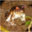

In [81]:
trans(data)

In [82]:
inputs = data.unsqueeze(0)

In [83]:
adv_inputs = attack.perturb(inputs)

In [84]:
adv_inputs.size()

torch.Size([1, 3, 32, 32])

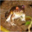

In [85]:
trans(adv_inputs.squeeze(0))

In [87]:
(inputs - adv_inputs).max()

tensor(0.0078)